<a href="https://colab.research.google.com/github/marth418/unsupervised-predict-streamlit-template/blob/master/Team_6_Recommenderf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Connecting to Comet

In [ ]:
# Prject workspace linked to Comet experiment for version control
from comet_ml import Experiment

experiment = Experiment(
    api_key="F3rSD8MTRVMEXv1vtpSFsaw9j",
    project_name="team-6-unsupervised-learning",
    workspace="gudani",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gudani/team-6-unsupervised-learning/f6f3ea8a93414361a02912ff4b83c322



## 2. Import Libraries

In [ ]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
# import sys
# !{sys.executable} -m pip install scikit-learn scikit-surprise
# !pip install git+https://github.com/gbolmier/funk-svd

# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Data Preprocessing
import random
from time import time
import cufflinks as cf
import comet_ml
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from datetime import datetime
from math import sqrt

# Models
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)

COMET INFO: Couldn't find a Git repository in 'C:\\Users\\GUDANI\\Videos\\edsa-movie-recommendation-wilderness' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`


## 3. Load Dataset

In [ ]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
movies_df=pd.read_csv('movies.csv')
imdb_df=pd.read_csv('imdb_data.csv')
g_scores_df=pd.read_csv('genome_scores.csv')
g_tags_df=pd.read_csv('genome_tags.csv')
links_df=pd.read_csv('links.csv')
tags_df=pd.read_csv('tags.csv')

### Feature Description

**Numeric**
* **budget:** - (continuous) dollar cost of production of the movie.
* **rating:** - (discrete) users rating of a movie from. **TARGET**
* **relevance:** - (continuous) measure (0-1) of the relevance of a genome tag to the movie, where 1 impies 100% relevance.
* **runtime:** - (continuos) movie duration in minutes.
* **timestamp:** - (continuous) the time at which a user rated the movie.


**Categorical**
* **director:** - (nominal) the person who controls the making of a film and supervises the actors and technical crew.
* **genres:** - (nominal) the style or category of the movie. A movie may belong to multiple (up to nineteen) genres, or may be absent a genre listing.
* **imdbId:** - (nominal) unique indentifying key for each IMBD entry. Can also be used in conjunction with the TMDB API.
* **movieId:** - (nominal) a unique identifier for each movie. There are 48,213 unique movies.
* **plot_keywords:** - (nominal) key words used to identify characteristics of a movie's storyline.
* **tag:** - (nominal) genome label
* **tagId:** - (nominal) unique genome identifier.
* **tmdbId:** - (nominal) unique identifier that works in conjunction with the TMDB API.
* **title:** - (nominal) the unique title identifying the movie. Included is a year of release enclosed in parenthesis at the end of the title.
* **title_cast:** - (nominal) the actors of the main characters in the movie. This does not include extras.
* **userId:** - (nominal) a unique identifier for each user. There are 162,541 unique users.


## 4. Exploratory Data Analysis

### 4.1 Data analysis

* Here we will look at the feature of the different datasets and their datatypes
* Explore the datasets shapes
* We will check for missing values
* Look at the data summary for the movies ratings

#### i) Train Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(train_df.columns), 'columns in the dataset')
print('There are', len(train_df), 'rows in the dataset')
train_df.head(5)

There are 4 columns in the dataset
There are 10000038 rows in the dataset


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


None

In [ ]:
#Check for missing values
print(str(train_df.isnull().sum()))

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


We can observe that this dataset consists of only numerical data and the are no missing values

In [ ]:
train_df['rating'].describe()

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

The mean rating is 3.5 while the minimum is 0.5.And approximately 10000040 ratings.

In [ ]:
display(train_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,10000038.0,8.119909e+04,4.679359e+04,1.0,4.051000e+04,8.091400e+04,1.215790e+05,1.625410e+05
movieId,10000038.0,2.138911e+04,3.919578e+04,1.0,1.197000e+03,2.947000e+03,8.630000e+03,2.091710e+05
rating,10000038.0,3.533395e+00,1.061124e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,10000038.0,1.215677e+09,2.268921e+08,789652009.0,1.011742e+09,1.199019e+09,1.447242e+09,1.574328e+09


#### ii) Test Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(test_df.columns), 'columns in the dataset')
print('There are', len(test_df), 'rows in the dataset')
test_df.head(5)

There are 2 columns in the dataset
There are 5000019 rows in the dataset


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [ ]:
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


None

In [ ]:
#Check for missing values
print(str(test_df.isnull().sum()))

userId     0
movieId    0
dtype: int64


The dataset also contains only numeric data and no missing were are detected.

In [ ]:
display(test_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,5000019.0,81216.467186,46797.108474,1.0,40518.5,80948.0,121599.0,162541.0
movieId,5000019.0,21362.936879,39183.892687,1.0,1196.0,2946.0,8622.0,209163.0


#### iii) Movies Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(movies_df.columns), 'columns in the dataset')
print('There are', len(movies_df), 'rows in the dataset')
movies_df.head(5)

There are 3 columns in the dataset
There are 62423 rows in the dataset


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
display(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


None

In [ ]:
#Check for missing values
print(str(movies_df.isnull().sum()))

movieId    0
title      0
genres     0
dtype: int64


This dataset consists of two columns with non-numeric data and one column with numeric data. There are no missing values in the dataset.

In [ ]:
display(movies_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
movieId,62423.0,122220.387646,63264.744844,1.0,82146.5,138022.0,173222.0,209171.0


#### iv) IMDB Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(imdb_df.columns), 'columns in the dataset')
print('There are', len(imdb_df), 'rows in the dataset')
imdb_df.head(5)

There are 6 columns in the dataset
There are 27278 rows in the dataset


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [ ]:
display(imdb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


None

In [ ]:
#Check for missing values
print(str(imdb_df.isnull().sum()))

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


The dataset consists of the mixture of non-numeric and numerical data. There are missing values in the columns for 'director', 'title_cast', 'runtime', 'budget' and 'plot_keywords'.

In [ ]:
display(imdb_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
movieId,27278.0,59855.480570,44429.314697,1.0,6931.25,68068.0,100293.25,131262.0
runtime,15189.0,100.312331,31.061707,1.0,89.00,98.0,109.00,877.0


#### v) Genome Scores Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(g_scores_df.columns), 'columns in the dataset')
print('There are', len(g_scores_df), 'rows in the dataset')
g_scores_df.head(5)

There are 3 columns in the dataset
There are 15584448 rows in the dataset


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [ ]:
display(g_scores_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


None

In [ ]:
#Check for missing values
print(str(g_scores_df.isnull().sum()))

movieId      0
tagId        0
relevance    0
dtype: int64


In [ ]:
display(test_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,5000019.0,81216.467186,46797.108474,1.0,40518.5,80948.0,121599.0,162541.0
movieId,5000019.0,21362.936879,39183.892687,1.0,1196.0,2946.0,8622.0,209163.0


#### vi) Genome Tags Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(g_tags_df.columns), 'columns in the dataset')
print('There are', len(g_tags_df), 'rows in the dataset')
g_tags_df.head(5)

There are 2 columns in the dataset
There are 1128 rows in the dataset


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [ ]:
display(g_tags_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


None

In [ ]:
#Check for missing values
print(str(g_tags_df.isnull().sum()))

tagId    0
tag      0
dtype: int64


In [ ]:
display(g_tags_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
tagId,1128.0,564.5,325.769857,1.0,282.75,564.5,846.25,1128.0


#### vii) Links Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(links_df.columns), 'columns in the dataset')
print('There are', len(links_df), 'rows in the dataset')
links_df.head(5)

There are 3 columns in the dataset
There are 62423 rows in the dataset


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
display(links_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


None

In [ ]:
#Check for missing values
print(str(links_df.isnull().sum()))

movieId      0
imdbId       0
tmdbId     107
dtype: int64


In [ ]:
display(links_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
movieId,62423.0,1.222204e+05,6.326474e+04,1.0,82146.50,138022.0,173222.00,209171.0
imdbId,62423.0,1.456706e+06,2.098007e+06,1.0,81686.50,325805.0,2063723.50,11170942.0
tmdbId,62316.0,1.551867e+05,1.533627e+05,2.0,36768.75,86750.5,255255.25,646282.0


#### viii) Tags Dataframe

In [ ]:
#The length of the dataset and the preview of the top 5 records
print('There are',len(tags_df.columns), 'columns in the dataset')
print('There are', len(tags_df), 'rows in the dataset')
tags_df.head(5)

There are 4 columns in the dataset
There are 1093360 rows in the dataset


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [ ]:
display(tags_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


None

In [ ]:
#Check for missing values
print(str(tags_df.isnull().sum()))

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


In [ ]:
display(tags_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,1093360.0,6.759022e+04,5.152114e+04,3.000000e+00,1.520400e+04,6.219900e+04,1.136420e+05,1.625340e+05
movieId,1093360.0,5.849276e+04,5.968731e+04,1.000000e+00,3.504000e+03,4.594000e+04,1.029030e+05,2.090630e+05
timestamp,1093360.0,1.430115e+09,1.177384e+08,1.135429e+09,1.339262e+09,1.468929e+09,1.527402e+09,1.574317e+09


### 4.2 Data Analysis and Visualiation

Here we will explore the data further using visuals.

#### i) Merge Datasets

In [ ]:
#Merge movies and imdb dataframe
movies_imdb_df = pd.merge(imdb_df, movies_df, left_on='movieId', right_on='movieId', how='left').drop('movieId', axis=1)
print('Shape:' ,movies_df.shape)

Shape: (62423, 3)


In [ ]:
movies_imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 0 to 27277
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_cast     17210 non-null  object 
 1   director       17404 non-null  object 
 2   runtime        15189 non-null  float64
 3   budget         7906 non-null   object 
 4   plot_keywords  16200 non-null  object 
 5   title          24866 non-null  object 
 6   genres         24866 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.7+ MB


In [ ]:
#Check for missing values
print(str(movies_imdb_df.isnull().sum()))

title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
title             2412
genres            2412
dtype: int64


In [ ]:
df = movies_imdb_df.copy()
df.head()

,title_cast,director,runtime,budget,plot_keywords,title,genres
0,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance
3,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy


There are a total of ***24,866*** movies with ***6+ features***. Most of the features have NaN values (apart from ***title*** and ***genres***). We will attempt at cleaning this dataset to a form suitable for analysis in the next section.

In [ ]:
# Merge movies and train dataframes
movie_rating_df = pd.merge(movies_df, train_df, left_on='movieId', right_on='movieId', how='left').drop('movieId', axis=1)
print('Shape:' ,movie_rating_df.shape)

Shape: (10014248, 5)


In [ ]:
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10014248 entries, 0 to 10014247
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   title      object 
 1   genres     object 
 2   userId     float64
 3   rating     float64
 4   timestamp  float64
dtypes: float64(3), object(2)
memory usage: 458.4+ MB


In [ ]:
#Check for missing values
print(str(movie_rating_df.isnull().sum()))

title            0
genres           0
userId       14210
rating       14210
timestamp    14210
dtype: int64


In [ ]:
df_two = movie_rating_df.copy()
df_two.head()

,title,genres,userId,rating,timestamp
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,158849.0,5.0,9.947168e+08
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,97203.0,5.0,9.426832e+08
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,161871.0,3.0,8.331046e+08
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,45117.0,4.0,1.442257e+09
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27431.0,5.0,8.496678e+08


#### ii) Visualization

Are there certain words that figure more often in Movie Titles and Movie Blurbs? I suspect there are some words which are considered more potent and considered more worthy of a title. Let us find out!

In [ ]:
movies_df['title'] = movies_df['title'].astype('str')
movies_df['genres'] = movies_df['genres'].astype('str')
imdb_df['plot_keywords'] = imdb_df['plot_keywords'].astype('str')
imdb_df['director'] = imdb_df['director'].astype('str')
imdb_df['title_cast'] = imdb_df['title_cast'].astype('str')


In [ ]:
title_corpus = ' '.join(movies_df['title'])
genres_corpus = ' '.join(movies_df['genres'])
plot_keywords_corpus = ' '.join(imdb_df['plot_keywords'])
director_corpus = ' '.join(imdb_df['director'])
title_cast_corpus = ' '.join(imdb_df['title_cast'])

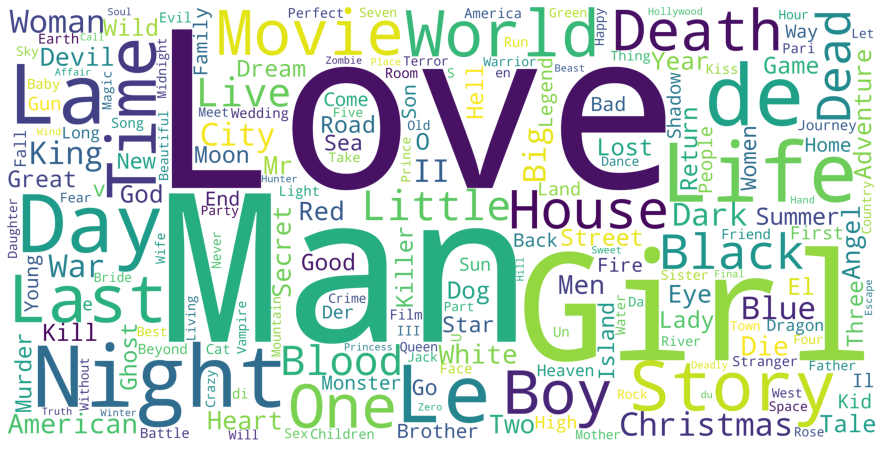

In [ ]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

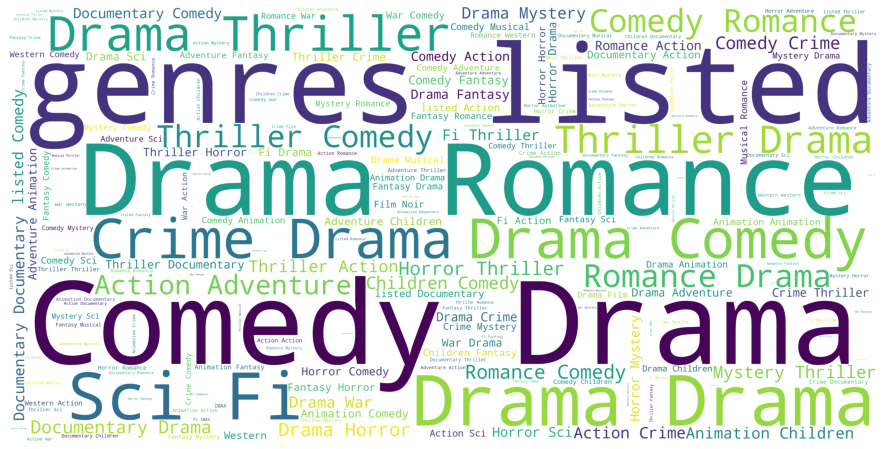

In [ ]:
genres_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(genres_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genres_wordcloud)
plt.axis('off')
plt.show()

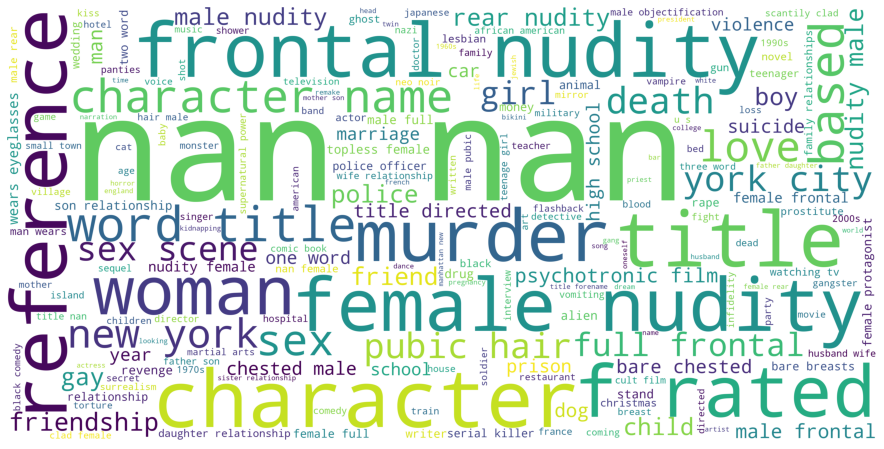

In [ ]:
plot_keywords_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(plot_keywords_corpus)
plt.figure(figsize=(16,8))
plt.imshow(plot_keywords_wordcloud)
plt.axis('off')
plt.show()

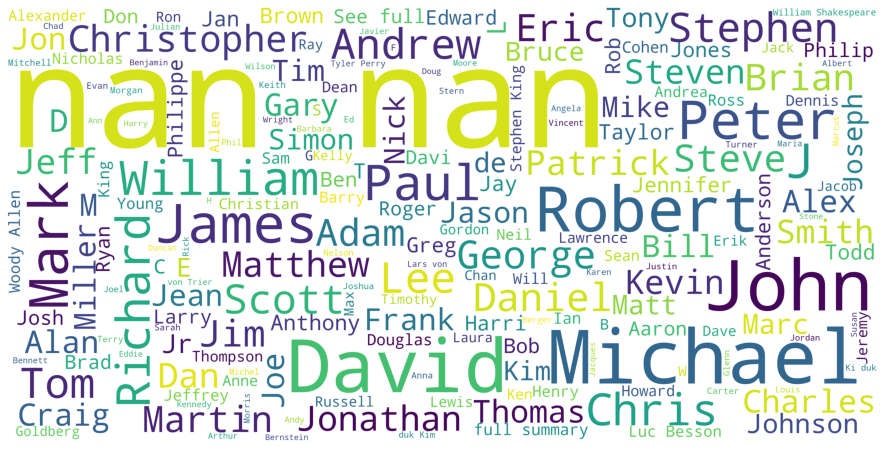

In [ ]:
director_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(director_corpus)
plt.figure(figsize=(16,8))
plt.imshow(director_wordcloud)
plt.axis('off')
plt.show()

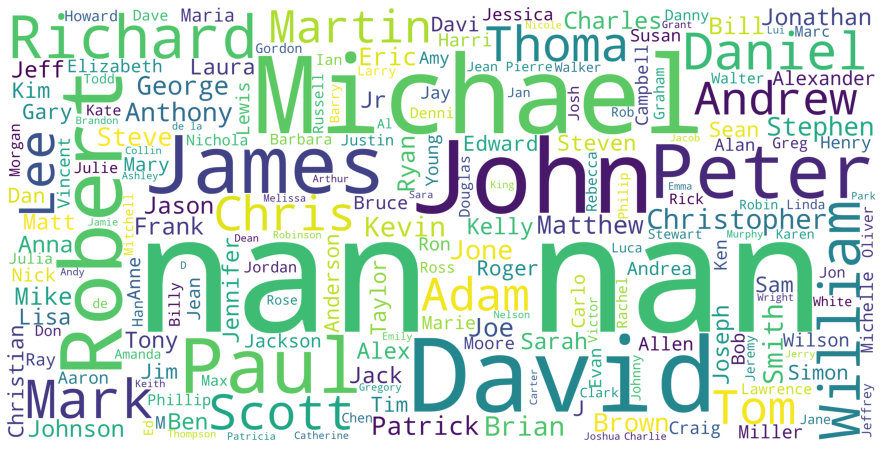

In [ ]:
title_cast_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_cast_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_cast_wordcloud)
plt.axis('off')
plt.show()

#### iii) Rating

In [ ]:
# Helper function to Change the numeric label in terms of Millions
def changingLabels(number):
    
    return str(number/10**6) + "M"

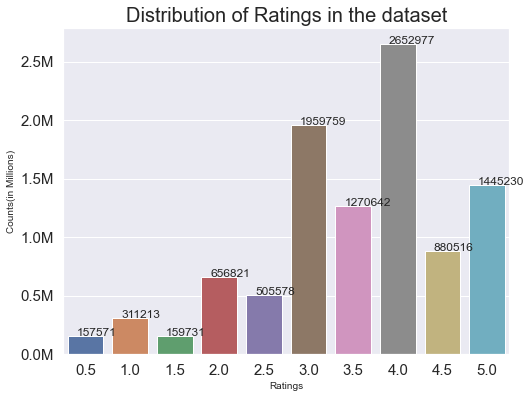

In [ ]:
# Visualising the distribution of the feature "rating"

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharey=True)

sns.countplot("rating", data=df_two, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

It is interesting that the ratings are left-skewed. It was expected that there would be a normal distrubtion with a mean rating of 3. Instead, we observe that users tend to rate movies quite favourably and tend to avoid negative ratings. This skew might be explained by the tendency of users to rate movies they liked. In other words, if a user doesn't like a movie, it is unlikely that they will watch it through to the end, let alone rate it.

#### Observations:

* The ratings given by users to movies lies in between 0.5 to 5.
* A high proportion of the movies have been rated 3, 3.5 or 4 by the users.
* The distribution of ratings look a bit left skewed as large proportion of ratings is in between 3 to 5.

Users that have rated the most movies:

In [ ]:
def user_ratings_count(df_two, n):

    plt.figure(figsize=(8,6))
    data = df_two['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index)
    for p in ax.patches:
        axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df_two['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df_two['movieId'].nunique())
    plt.show()

Combined number of ratings:	 34398 
Total number of movies:		 48213


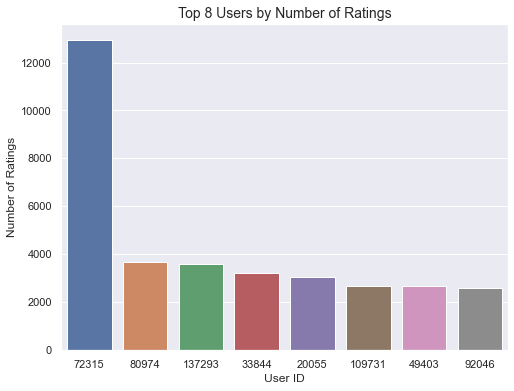

In [ ]:
user_ratings_count(train_df,8)

In [ ]:
# Exclude user 72315 for EDA
df_two_new = df_two[df_two['userId']!=72315]

KeyError: 'movieId'

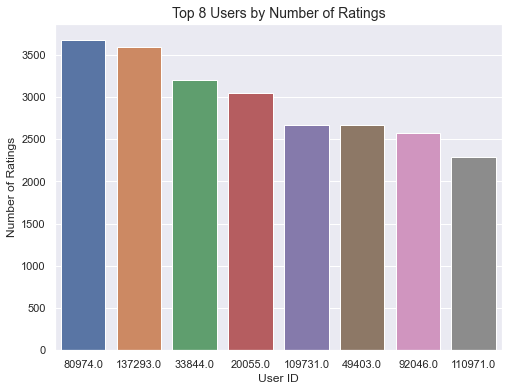

In [ ]:
user_ratings_count(df_two_new,8)

    How do users tend to rate movies?

## 5. Feature Engineering

Feature engineering refers to a process of selecting and transforming variables/features in the dataset when creating a predictive model using machine learning. Therefore we have to extract the features from the raw dataset before training the model data in machine learning algorithms. 
Feature engineering has two goals: 

a) Preparing the proper input dataset, compatible with the machine learning algorithm            requirements 
         
b) Improving the performance of machine learning models.

### 5.1 Extracting year and genre

If we look at our movie dataset, we can see that every title contains the release year of the movie. In this section we extract the year from the title column

In [ ]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


We firstly use regular expressions to find a year stored between parentheses so that we don't select movies that have years in their titles. we extract the year with the parentheses from the title to the new calumn 'year' as shown below.

In [ ]:
#Making a copy of movies_df to work with
#Using regular expressions to find a year stored between parentheses
#so that we don't select movies that have years in their titles
df_movies = movies_df.copy(deep = True)
df_movies['year'] = df_movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,(1995)
1,2,Jumanji (1995),Adventure|Children|Fantasy,(1995)
2,3,Grumpier Old Men (1995),Comedy|Romance,(1995)


Unfortunately, every entry in the year column have paratheses, so we are now removing them so that the year column can be numeric and the year inside will be a valid year

In [ ]:
#Removing the parentheses
df_movies['year'] = df_movies.year.str.extract('(\d\d\d\d)',expand=False)
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


In [ ]:
#Deleting the years from the 'title' column
df_movies['title'] = df_movies.title.str.replace('(\(\d\d\d\d\))', '')
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995


In [ ]:
#Applying the strip function to get rid of any whitespace characters which might be at the end of a title
df_movies['title'] = df_movies['title'].apply(lambda x: x.strip())
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


From the table above, the genre column has a veritcal bar |, so we remove it and create the list of the genre, as shown below

In [ ]:
#Every genre is separated by a | so we call the split function on |
df_movies['genres'] = df_movies.genres.str.split('|')
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995


### 5.2 Removing missing values

We now check the missing values in our data, from the output of the code below, it is clear that only the year column have null or missing values

In [ ]:
#Checking for missing values
df_movies.isna().sum()

movieId      0
title        0
genres       0
year       410
dtype: int64

Now we fill all the missing values in the year column by 0 due to the fact that null values affects the performance of the model

In [ ]:
# Filling in the missing values
df_movies.year.fillna(0, inplace=True)

### 5.3 Reducing memory size

We check the computer memory occupied by the dataset, and the year is stored as an int64 but it has only four digit, so we convert it to int16 because the four digits can fit without any data loss.

In [ ]:
#Checking for memory usage in the original movies dataframe
df_movies_original_mem = df_movies.memory_usage()
df_movies_original_mem

Index         128
movieId    499384
title      499384
genres     499384
year       499384
dtype: int64

In [ ]:
# Let's save space by converting the year column from int64 to int16, since it holds a max of just 4 digits of numbers.
df_movies.year = df_movies.year.astype('int16')

## 5.4 Feature engineering for Content based filtering recommender system

Since we are building the content based and the collaborative based filtering system. These systems are built using different features, so in this section we focus on features required for building the content based filtering sytem.



##### 5.4.1 encoding genre

Unlike the collaborative filtering algorithm, the content based requires the genre column  to be used. Since the genre column is categorical, we firstly use one-hot-encoding on and create a column for each. If the movie is of a particular genre, the intersection of that movie and gener will have 1 or else the intersection will have 0.

In [ ]:
# First let's make a copy of df_movies
movies_genres = df_movies.copy(deep=True)

# Let's iterate through df_movies, then append the movie genres as columns of 1s or 0s.
# 1 if that column contains movies in the genre at the present index and 0 if not.

x = []
for index, row in df_movies.iterrows():
    x.append(index)
    for genre in row['genres']:
        movies_genres.at[index, genre] = 1

# Confirm that every row has been iterated and acted upon
print(len(x) == len(df_movies))

#Let's inspect the dataframe
movies_genres.head(20)

True


,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,[Comedy],1995,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Heat,"[Action, Crime, Thriller]",1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,Sabrina,"[Comedy, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,Sudden Death,[Action],1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unfortunately, we have null values, so we fill these null values with a 0 indicating that the movie does not fall in that genre.

In [ ]:
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
movies_genres = movies_genres.fillna(0)
movies_genres.head(3)

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 5.4.2 Inspecting the training dataset 

Looking at the training dataset in the output of the code below, we can see that we have the timestamp feature, which is not required when building the content based model, so we are dropping the timestamp column.

In [ ]:
# Renaming the training dataset to ratings
ratings_df = train_df.copy(deep=True)

#Checking the shape of the dataset
print('Ratings_df shape:',ratings_df.shape) 

#Inspecting the dataset
ratings_df.head()

Ratings_df shape: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
# Dropping the timestamp column
ratings_df.drop('timestamp', axis=1, inplace=True)

# Confirming the drop
ratings_df.head(3)

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0


From the output of the code below, it is clear that the train dataset is of the correct data type, and it does not have nulls it is ready for modelling.

In [ ]:
# Let's confirm the right data types exist per column in ratings data_set
ratings_df.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [ ]:
# Let's check for missing values
ratings_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

## 5.5 Content based filtering recommender system

Now we can start with the Content-Based or Item-Item recommendation systems. This method looks at similarities between features of items and recommends items to a user based on their similarities with the user's favourite item/s. 

We start by creating an input user to recommend movies to. We assume that the user has rated the following movies with the following ratings:-



Step 1: Creating the user's Profile 

In [ ]:
# so on a scale of 0 to 5, with 0 min and 5 max, see the user's movie ratings below
user_movie_ratings = [
            {'title':'Predator', 'rating':4.9},
            {'title':'Final Destination', 'rating':4.9},
            {'title':'Toy Story', 'rating':4},
            {'title':"Casino", 'rating':3},
            {'title':'Jumanji', 'rating':4.1},
            {'title':'Waiting to Exhale', 'rating':3.9},
            {'title':'Tom and Huck', 'rating':4.1},
            {'title':'Omen, The', 'rating':5.0}
         ] 
user_movie_ratings = pd.DataFrame(user_movie_ratings)
user_movie_ratings

,title,rating
0,Predator,4.9
1,Final Destination,4.9
2,Toy Story,4.0
3,Casino,3.0
4,Jumanji,4.1
5,Waiting to Exhale,3.9
6,Tom and Huck,4.1
7,"Omen, The",5.0


With the user's input complete, let's extract the input movie's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movie's title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [ ]:
# Extracting movie Ids from movies_df and updating user_movie_ratings with movie Ids.
user_movie_Id = df_movies[df_movies['title'].isin(user_movie_ratings['title'])]

# Merging user movie Id and ratings into the user_movie_ratings data frame. 
user_movie_ratings = pd.merge(user_movie_Id, user_movie_ratings)

# Display the merged and updated data frame.
user_movie_ratings

,movieId,title,genres,year,rating
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,4.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,4.1
2,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,3.9
3,8,Tom and Huck,"[Adventure, Children]",1995,4.1
4,16,Casino,"[Crime, Drama]",1995,3.0
5,1350,"Omen, The","[Horror, Mystery, Thriller]",1976,5.0
6,45662,"Omen, The","[Horror, Thriller]",2006,5.0
7,3409,Final Destination,"[Drama, Thriller]",2000,4.9
8,3527,Predator,"[Action, Sci-Fi, Thriller]",1987,4.9


In [ ]:
#Dropping the year and genres columns as we do not need them
user_movie_ratings = user_movie_ratings.drop(['genres','year'], 1)


#Final input dataframe
user_movie_ratings

,movieId,title,rating
0,1,Toy Story,4.0
1,2,Jumanji,4.1
2,4,Waiting to Exhale,3.9
3,8,Tom and Huck,4.1
4,16,Casino,3.0
5,1350,"Omen, The",5.0
6,45662,"Omen, The",5.0
7,3409,Final Destination,4.9
8,3527,Predator,4.9


Step 2: Learning the user's Profile

We're going to start by learning the input's preferences, so let's get the subset of movies that the input has watched from the Dataframe containing genres defined with binary values.

In [ ]:
# filter the selection by outputing movies that exist in both user_movie_ratings and movies_genres
user_genres_df = movies_genres[movies_genres.movieId.isin(user_movie_ratings.movieId)]
user_genres_df

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,16,Casino,"[Crime, Drama]",1995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1315,1350,"Omen, The","[Horror, Mystery, Thriller]",1976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3314,3409,Final Destination,"[Drama, Thriller]",2000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3429,3527,Predator,"[Action, Sci-Fi, Thriller]",1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10826,45662,"Omen, The","[Horror, Thriller]",2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We'll only need the actual genre table, so let's clean this up a bit by resetting the index and dropping the movieId, title, genres and year columns.

In [ ]:
# First, let's reset index to default and drop the existing index.
user_genres_df.reset_index(drop=True, inplace=True)

# Next, let's drop redundant columns
user_genres_df.drop(['movieId','title','genres','year'], axis=1, inplace=True)

# Let's view changes
user_genres_df

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Step 3: Now we build the user's Profile

To do this, we're going to turn each genre into weights, by multiplying the user's movie ratings by user_genres_df table. And then summing up the resulting table by column. First let's confirm the shapes of the data frames we have recently defined

In [ ]:
# let's confirm the shapes of our dataframes to guide us as we do matrix multiplication

print('Shape of user_movie_ratings is:',user_movie_ratings.shape)
print('Shape of user_genres_df is:',user_genres_df.shape)

Shape of user_movie_ratings is: (9, 3)
Shape of user_genres_df is: (9, 20)


In [ ]:
# Let's find the dot product of transpose of user_genres_df by user rating column
user_profile = user_genres_df.T.dot(user_movie_ratings.rating)

# Let's see the result
user_profile

Adventure             12.2
Animation              4.0
Children              12.2
Comedy                 7.9
Fantasy                8.1
Romance                3.9
Drama                 11.9
Action                 4.9
Crime                  3.0
Thriller              19.8
Horror                 9.9
Mystery                5.0
Sci-Fi                 4.9
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

From the output we notice that the user loves 'Thriller', 'Children', 'Adventure' and 'Romance' movies the most.
Now, we have the weights for all the user's preferences. This is known as the User Profile. We can now recommend movies that might interest the user.
Let's start by editing the original movies_with_genres data frame that contains all movies and their genres columns.

In [ ]:
# let's set the index to the movieId
movies_genres = movies_genres.set_index(movies_genres.movieId)

# let's view the head
movies_genres.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,,,,,
1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's delete irrelevant columns from the movies_genres dataframe that contains all 62423 movies and distinctive columns of genres.

In [ ]:
# Deleting four unnecessary columns.
movies_genres.drop(['movieId','title','genres','year'], axis=1, inplace=True)

# Viewing changes
movies_genres.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With user's profile and the complete list of movies and their genres in hand, we're going to take the weighted average of every movie based on the user's profile and recommend the top twenty movies that match their preference.

In [ ]:
# Multiply the genres by the weights and then take the weighted average.
recommendation_table_df = (movies_genres.dot(user_profile)) / user_profile.sum()

# Let's view the recommendation table
recommendation_table_df.head()

movieId
1    0.412256
2    0.301764
3    0.109564
4    0.220056
5    0.073352
dtype: float64

Let's sort the recommendation table in descending order

In [ ]:
# Let's sort values from higest to lowest
recommendation_table_df.sort_values(ascending=False, inplace=True)

#A look at the values
recommendation_table_df.head(20)

movieId
81132     0.692665
5018      0.675952
6902      0.648097
147051    0.621170
71999     0.610028
83266     0.609099
117646    0.601671
149488    0.601671
43932     0.598886
144324    0.590529
72165     0.583101
2617      0.583101
2414      0.577530
201869    0.574745
194388    0.573816
27781     0.570102
142418    0.562674
4956      0.562674
26093     0.558960
128985    0.557103
dtype: float64

Finally we have the recommendation table with movie details and genres for the top 20 movies that match the user's profile.

In [ ]:
# first we make a copy of df_movies
copy = df_movies.copy(deep=True)

# Then we set its index to movieId
copy = copy.set_index('movieId', drop=True)

# Next we enlist the top 20 recommended movieIds we defined above
top_20_index = recommendation_table_df.index[:20].tolist()

# finally we slice these indices from the copied movies df and save in a variable
recommended_movies = copy.loc[top_20_index, :]

# Now we can display the top 20 movies in descending order of preference
recommended_movies

,title,genres,year
movieId,,,
81132,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010
5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
6902,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002
147051,Manichitrathazhu,"[Children, Drama, Fantasy, Horror, Mystery, Th...",1993
71999,Aelita: The Queen of Mars (Aelita),"[Action, Adventure, Drama, Fantasy, Romance, S...",1924
83266,Kaho Naa... Pyaar Hai,"[Action, Adventure, Comedy, Drama, Mystery, Ro...",2000
117646,Dragonheart 2: A New Beginning,"[Action, Adventure, Comedy, Drama, Fantasy, Th...",2000
149488,Christmas Town,"[Action, Children, Comedy, Drama, Fantasy, Thr...",2008
43932,Pulse,"[Action, Drama, Fantasy, Horror, Mystery, Sci-...",2006


These are the top 20 movies recommended for our user.

## 5.6 Feature engineering for Collaborative based method

This method looks at the user of interest's likes/ interests, compares these with those of other users. After identifying users with similar likes to our user of interest, it then recommends items that other users like that our user of interest has not been exposed to.

Here again we will be using the ratings and movies datasets. We take a look at the datasets to remind ourselves what look like.

In [ ]:
ratings_df.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [ ]:
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


We make copies of this dataframe to work with

In [ ]:
df_ratings_copy = ratings_df.copy(deep=True)
df_movies_copy = df_movies.copy(deep=True)

The genre column is not needed for collaborative filtered, we therefore drop the column from the movies dataset.

In [ ]:
#Dropping the genre column
df_movies_copy.drop(['genres'], axis=1, inplace = True)
df_movies_copy.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


We created our user profile above under the content based method. We have a look at the dataset to remind ourselves what it looks like.

In [ ]:
user_movie_ratings

,movieId,title,rating
0,1,Toy Story,4.0
1,2,Jumanji,4.1
2,4,Waiting to Exhale,3.9
3,8,Tom and Huck,4.1
4,16,Casino,3.0
5,1350,"Omen, The",5.0
6,45662,"Omen, The",5.0
7,3409,Final Destination,4.9
8,3527,Predator,4.9


We need to now add the movieId column from the movie dataframe into the user_movie_ratings Dataframe. First filter out the rows that contain the user_movie_ratings' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [ ]:
#Filtering out the movies by title
Id = df_movies_copy[df_movies_copy['title'].isin(user_movie_ratings['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
user_movie_ratings = pd.merge(Id, user_movie_ratings)
#Dropping information we won't use from the input dataframe
user_movie_ratings = user_movie_ratings.drop('year', 1)
user_movie_ratings

,movieId,title,rating
0,1,Toy Story,4.0
1,2,Jumanji,4.1
2,4,Waiting to Exhale,3.9
3,8,Tom and Huck,4.1
4,16,Casino,3.0
5,1350,"Omen, The",5.0
6,3409,Final Destination,4.9
7,3527,Predator,4.9
8,45662,"Omen, The",5.0


Now we find the users who have seen the same movies from the ratings dataframe with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies that our user of interest likes.

In [ ]:
#Filtering out users that have watched movies that our user of interest has watched and storing them
users = df_ratings_copy[df_ratings_copy['movieId'].isin(user_movie_ratings['movieId'].tolist())]
users.head(10)

,userId,movieId,rating
99,129683,3409,3.0
119,158849,1,5.0
154,97203,1,5.0
194,161871,1,3.0
400,68492,4,4.0
720,45117,1,4.0
982,39057,45662,3.0
1305,27431,1,5.0
1483,36833,1,4.0
2242,28491,16,4.0


In [ ]:
#Checking the shape of users
users.shape

(53756, 3)

53756 users have watched and rated the same movies that our user of interest likes.

In [ ]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = users.groupby(['userId'])

In [ ]:
#showing one such group example by getting all the users of a particular userId
userSubsetGroup.get_group(72315)

,userId,movieId,rating
1549313,72315,2,3.0
4342138,72315,1350,3.5


In [ ]:
#Sorting dataframe so users with movies most in common with our user of interest will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

In [ ]:
userSubsetGroup[0:3]

[(36883,
           userId  movieId  rating
  1419493   36883        4     2.0
  3140876   36883     3527     2.0
  3833790   36883     1350     2.0
  5661356   36883        1     3.0
  7692606   36883        8     1.0
  9446011   36883        2     2.0
  9934268   36883       16     2.5),
 (39916,
           userId  movieId  rating
  741362    39916        2     4.5
  4130181   39916     1350     3.5
  4239529   39916       16     5.0
  4490325   39916        1     4.5
  4752449   39916    45662     4.0
  5196408   39916     3409     4.5
  7985071   39916     3527     5.0),
 (24678,
           userId  movieId  rating
  581699    24678     1350     4.5
  1062564   24678       16     4.0
  4060116   24678     3409     3.5
  6200854   24678     3527     5.0
  6693898   24678        2     3.0
  7189721   24678        1     4.5)]

Now we are going to compare all users to our user of interest and find the one that is most similar.

In [ ]:
userSubsetGroup = userSubsetGroup[0:100]

In [ ]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    user_movie_ratings = user_movie_ratings.sort_values(by='movieId')
    #Get the N for the formula
    n = len(group)
    #Get the review scores for the movies that they both have in common
    temp = user_movie_ratings[user_movie_ratings['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp['rating'].tolist()
    #put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(n)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(n)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorDict[name] = 0

In [ ]:
#Having a look at the pearson dict items
pearsonCorDict.items()

dict_items([(36883, -0.27474576945765783), (39916, -0.5539003119294533), (24678, 0.2415149117668177), (33793, -0.46114852486385616), (34997, -0.37998029782867043), (39896, -0.5219291346312716), (60305, -0.051497156662986765), (89457, 0.5405899027195897), (8619, -0.386524825887321), (11952, -0.589108632455502), (15121, -0.5033806879428587), (17836, -0.24059045989203795), (18914, 0.5623047891664276), (22522, 0.5439378156912114), (30643, 0.6047078979069535), (42735, -0.998007992603659), (44034, -0.6583261286893919), (47745, -0.9713567326736667), (48928, 0), (54665, -0.39316682549745685), (58139, 0.12467574523851255), (61109, -0.23543087025324602), (69153, 0.6276524957315458), (85115, 0.34000230477142745), (96495, 0.5793103474128148), (96818, -0.13049646848710525), (98001, -0.3137838296250855), (113881, -0.6248373498543325), (113917, -0.04730660902673562), (120403, -0.24549951047446408), (121380, 0.2616801467242556), (128525, 0.44506437376260516), (130070, 0.2132246486356908), (136570, 0.6

In [ ]:
#Creating a pearson dataframe
pearsonDF = pd.DataFrame.from_dict(pearsonCorDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,-0.274746,36883
1,-0.553900,39916
2,0.241515,24678
3,-0.461149,33793
4,-0.379980,34997


In [ ]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
92,0.976822,31734
67,0.875978,19042
47,0.855921,6118
55,0.790289,11930
77,0.748835,23672


Rating of selected users to all movies We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our pearsonDF from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [ ]:
topUsersRating=topUsers.merge(df_ratings_copy, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,0.976822,31734,296,4.5
1,0.976822,31734,8965,2.0
2,0.976822,31734,53435,3.0
3,0.976822,31734,1589,3.0
4,0.976822,31734,64983,3.0


We multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

In [ ]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,0.976822,31734,296,4.5,4.395698
1,0.976822,31734,8965,2.0,1.953644
2,0.976822,31734,53435,3.0,2.930466
3,0.976822,31734,1589,3.0,2.930466
4,0.976822,31734,64983,3.0,2.930466


In [ ]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,11.607052,44.609116
2,9.777034,32.750108
3,3.496945,9.704803
4,2.555136,7.916224
5,0.346053,1.652796


In [ ]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,3.843277,1
2,3.349698,2
3,2.775223,3
4,3.098161,4
5,4.776141,5


In [ ]:
#We sort the weighted average recommendation score in descending order and display the top 10
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
4483,263.252011,4483
4133,100.241150,4133
6212,85.330777,6212
72720,76.635589,72720
30822,72.564766,30822
32298,61.044690,32298
59615,60.049161,59615
4994,56.007630,4994
3794,55.195393,3794


In [ ]:
recommendation_df.shape

(7190, 2)

In [ ]:
#Extracting the further information (eg 'title') about the movies in recommendation_df from movies_df
#Displaying the top 20 recommended movies
df_movies_copy.loc[df_movies_copy['movieId'].isin(recommendation_df.head(20)['movieId'].tolist())]

,movieId,title,year
95,97,"Hate (Haine, La)",1995
188,190,Safe,1995
469,474,In the Line of Fire,1993
512,517,Rising Sun,1993
3380,3477,Empire Records,1995
3693,3794,Chuck & Buck,2000
3874,3978,"Legend of Bagger Vance, The",2000
4029,4133,Masters of the Universe,1987
4212,4317,Love Potion #9,1992
4378,4483,Caddyshack II,1988


## End of recommender system

In [ ]:
# Renaming the timestamp to date
movie_rating_df.rename(columns={"timestamp": "date"}, inplace=True)

In [ ]:
# Sorting ratings based on date
movie_rating_df.sort_values(by = "date", inplace = True)
movie_rating_df.reset_index(drop=True, inplace=True)

In [ ]:
# Checking the features and no. of records in the merged dataset

print("records:", movie_rating_df.shape[0])
print("features: ", movie_rating_df.shape[1])
print("The list of features is : ", movie_rating_df.columns)
movie_rating_df.head()

records: 10014248
features:  5
The list of features is :  Index(['title', 'genres', 'userId', 'rating', 'date'], dtype='object')


,title,genres,userId,rating,date
0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2262.0,5.0,789652009.0
1,Clueless (1995),Comedy|Romance,102689.0,5.0,822873600.0
2,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,124805.0,5.0,822873600.0
3,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller,109832.0,4.0,822873600.0
4,Ace Ventura: When Nature Calls (1995),Comedy,71732.0,1.0,822873600.0


#### 5.5.2 duplicates and nulls

In [ ]:
# Sorting ratings based on date
movie_rating_df.sort_values(by = "date", inplace = True)
movie_rating_df.reset_index(drop=True, inplace=True)

Since the null values and duplicates affects the performance of the model, we check if our dataset have null values and duplicates; and from the output below, it is clear that there are no duplicates and null values.

In [ ]:
# Check for null values in new merged dataframe
movie_rating_df.isnull().sum()

title         0
genres        0
userId    14210
rating    14210
date      14210
dtype: int64

In [ ]:
# Checking for duplicates in the dataset
print("No. of duplicates records in the dataset : ", movie_rating_df.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


#### 5.5.4 adding more features for training

so we now add the imdb and the movie dataset because they have some features for building the model

In [ ]:
# Merging the movies and train_df data files for data analysis
key_cast_ratings = train_df.merge(imdb_df, how="left", on="movieId")

In [ ]:
key_cast_ratings.head(3)

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...


In [ ]:
eda_df = key_cast_ratings.merge(df_movies, how = 'left', on = 'movieId')

In [ ]:
eda_df.head(3)

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres,year
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002


#### 5.5.5 removing unnecessary features

we remove the runtime and the budget features bacause we don't need them that much and having more feature can slow down our model

In [ ]:
EDA_Fin = eda_df.drop(['runtime', 'budget'], axis = 1)

In [ ]:
EDA_Fin.head(3)

,userId,movieId,rating,timestamp,title_cast,director,plot_keywords,title,genres,year
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,dwarf|bruges|irish|hitman,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002


from the output of the code below, we can see that there are no nulls in our marged dataset, so  it is now ready to be sent to the modelling phase.

In [ ]:
cleaned_eda = EDA_Fin.dropna(axis = 0, how ='any')
cleaned_eda.isnull().sum()

userId           0
movieId          0
rating           0
timestamp        0
title_cast       0
director         0
plot_keywords    0
title            0
genres           0
year             0
dtype: int64

In [ ]:
cleaned_eda.head(3)

,userId,movieId,rating,timestamp,title_cast,director,plot_keywords,title,genres,year
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,dwarf|bruges|irish|hitman,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002


## 6. Data Preprocessing

### Multidimensional Scaling

Multidimensional scaling (MDS) is a technique for visualizing distances between objects on a map, where the distance is known between pairs of the objects.

In [ ]:
# Subset the data to cut down computation time for now
g_scores = g_scores_df[:10000000]

In [ ]:
# Although scores are in the range of 0-1, there is no harm in scaling
scaler_mds = StandardScaler()
mds_genome = scaler_mds.fit_transform(g_scores.sample(frac=0.0001))

In [ ]:
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)

In [ ]:
tsne.fit(mds_genome)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.388s...
[t-SNE] Computed neighbors for 1000 samples in 1.878s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.126498
[t-SNE] Computed conditional probabilities in 0.286s
[t-SNE] Iteration 50: error = 84.2871094, gradient norm = 0.0000245 (50 iterations in 1.803s)
[t-SNE] Iteration 100: error = 84.2871094, gradient norm = 0.0000033 (50 iterations in 0.918s)
[t-SNE] Iteration 150: error = 84.2871094, gradient norm = 0.0000034 (50 iterations in 0.821s)
[t-SNE] Iteration 200: error = 84.2871094, gradient norm = 0.0000071 (50 iterations in 0.682s)
[t-SNE] Iteration 250: error = 84.2871094, gradient norm = 0.0000203 (50 iterations in 0.641s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.287109
[t-SNE] Iteration 300: error = 4.5390201, gradient norm = 0.0000323 (50 iterations in 0.670s)
[t-SNE] Iteration 350: error = 4.5390186, gradient norm = 0.00008

TSNE(learning_rate=0.1, n_components=3, n_jobs=-1, perplexity=10, verbose=2)

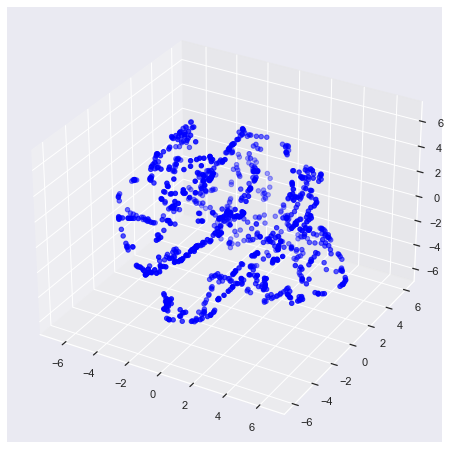

In [ ]:
Axes3D

fig = plt.figure(figsize=(15, 8))

# Add 3D scatter plot
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], tsne.embedding_[:,2], color='blue')
plt.show()

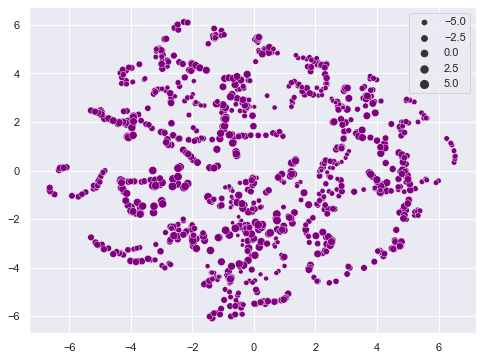

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsne.embedding_[:,0], y = tsne.embedding_[:,1], size=tsne.embedding_[:,2],color='purple')
plt.show()

## Principal Component Analysis

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance. 

In [ ]:
# Pivoting the dataframe
pca_data_pivoted = g_scores_df.pivot_table(
        values='relevance', index='movieId', columns='tagId',
        fill_value=0, aggfunc='mean')

In [ ]:
pca_data_pivoted.columns = list(g_tags_df['tag'])

In [ ]:
pca_data_pivoted.head()

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,...,wistful,witch,witches,witty,wizards,women,working class,workplace,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,0.58025,0.10250,0.20175,0.00700,0.02450,0.17275,0.01650,0.10400,...,0.07150,0.03325,0.10550,0.69400,0.10800,0.08925,0.05500,0.07700,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,0.08800,0.10275,0.14525,0.00700,0.00450,0.02750,0.01075,0.15925,...,0.02225,0.24300,0.38525,0.18725,0.21700,0.13525,0.01800,0.08725,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,0.02450,0.06475,0.08100,0.00550,0.00500,0.03475,0.00675,0.11375,...,0.02500,0.01950,0.02950,0.22325,0.02650,0.35075,0.02150,0.07325,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,0.02800,0.03475,0.07775,0.01325,0.00325,0.02650,0.01875,0.13375,...,0.03850,0.02275,0.03625,0.10725,0.02875,0.97525,0.02075,0.38650,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,0.02775,0.03300,0.05050,0.00825,0.00300,0.02525,0.01800,0.15475,...,0.03275,0.02450,0.03500,0.10475,0.03350,0.40225,0.01875,0.11200,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [ ]:
features = [col for col in pca_data_pivoted.columns]

### Scales of measurement

It is important that we scale the data before dimensionality reduction.

Although all variables are measured on the same scale (0-1), there shouldn't be any downside to setting the mean to zero and standard deviation to 1

In [ ]:
def scaler(df):
    """
    Scales data.
    """
    scaler = StandardScaler(with_std=True)
    scaled_data = scaler.fit_transform(df)
    return scaled_data

In [ ]:
pca_scaled = scaler(pca_data_pivoted)

In [ ]:
scaled_pca = pd.DataFrame(pca_scaled, 
index = pca_data_pivoted.index, columns = pca_data_pivoted.columns)

In [ ]:
scaled_pca

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,...,wistful,witch,witches,witty,wizards,women,working class,workplace,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.249680,-0.335814,-0.141516,-0.114504,0.078419,0.555343,-0.105515,0.165267,0.783238,-0.409354,6.221019,0.340802,0.547270,-0.266926,0.591953,1.786563,-0.119751,-0.908390,...,-0.010704,-0.195175,0.352315,2.924121,0.674008,-0.908924,-0.092111,-0.475196,-0.566859,-0.353325,-0.124865,-0.330958,-0.847037,-0.439618,-0.038112,-0.097353,-0.394287,-0.115347
2,-0.074795,-0.068236,-0.139275,-0.033125,-0.260840,-0.257677,-0.048234,-0.604289,-0.151909,-0.194171,0.455035,0.343077,0.137612,-0.266926,-0.108359,-0.405395,-0.266961,-0.569922,...,-0.534079,1.846085,3.296897,-0.300735,1.986048,-0.657022,-0.483653,-0.386628,-0.478667,-0.335295,-0.247889,-0.511484,-1.002054,-0.719252,-0.280445,-0.235528,-0.197868,-0.141923
3,0.002154,0.171385,-0.439478,0.016283,-0.557479,-0.386048,-0.279850,-0.270398,-0.509575,-0.330206,-0.288774,-0.002728,-0.328238,-0.303488,-0.090852,-0.295985,-0.369369,-0.848660,...,-0.504855,-0.328988,-0.447643,-0.071638,-0.307012,0.523083,-0.446616,-0.507600,-0.403337,-0.290219,-0.181251,-0.475379,-1.004094,-0.696881,-0.334297,-0.183943,-0.334403,-0.165545
4,-0.172731,-0.108173,-0.338663,-0.634745,-0.438142,-0.500157,-0.449203,-0.672138,-0.483495,-0.401934,-0.247777,-0.275732,-0.351803,-0.114587,-0.152129,-0.420486,-0.062146,-0.726138,...,-0.361392,-0.297360,-0.376594,-0.809839,-0.279929,3.942923,-0.454552,2.199148,-0.473155,-0.188047,-0.218842,-0.285827,-0.514567,-0.297005,-0.344394,-0.211578,-0.358356,-0.198026
5,-0.050312,0.135442,-0.361067,-0.518490,-0.513154,-0.200623,-0.461656,-0.743559,-0.561734,-0.419248,-0.250705,-0.291657,-0.549381,-0.236458,-0.160883,-0.439349,-0.081348,-0.597489,...,-0.422496,-0.280329,-0.389751,-0.825749,-0.222753,0.805104,-0.475717,-0.172766,-0.471318,-0.278199,-0.235928,-0.445291,-0.430940,-0.786364,-0.344394,-0.220789,-0.372728,-0.186215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205072,-0.365105,-0.431662,0.319990,-0.570805,1.247927,-0.490647,0.327830,1.418697,-0.593402,2.882694,0.173910,-0.168805,0.772038,-0.321769,-0.064590,0.254834,-0.113350,-0.600552,...,-0.385302,-0.253566,0.481256,1.436583,2.720309,-0.758330,-0.391059,-0.120921,0.507980,-0.085876,-0.126574,0.800336,-0.859276,3.659811,-0.105427,-0.143411,2.791525,0.699626
205076,-0.116768,-0.212009,-0.414834,-0.376077,0.540426,-0.169719,-0.078120,0.697350,-0.651151,-0.441508,-0.218493,-0.207481,-0.582009,-0.273020,2.544076,7.513573,-0.068547,-0.530102,...,0.005237,-0.423874,-0.355543,0.377010,0.039053,-0.673450,0.204191,0.060537,1.176769,-0.136962,-0.013802,-0.370072,-0.120906,-0.380895,-0.001089,-0.012606,-0.509263,-0.097631
205383,-0.078293,-0.072230,-0.455160,-0.082533,0.465414,0.854877,0.967886,0.886614,0.531754,-0.233745,-0.075002,-0.257532,0.685031,-0.157242,-0.117113,-0.062076,-0.023744,1.016746,...,-0.401242,-0.246267,-0.139764,0.130412,-0.189651,0.943376,-0.171478,-0.341263,0.349970,-0.133957,-0.169290,-0.321932,-0.335074,-0.132021,0.056129,-0.102880,-0.082891,0.088396


Text(0, 0.5, 'Cumulative explained variance')

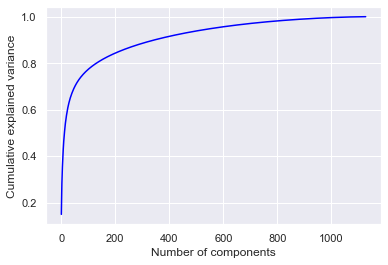

In [ ]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(pca_data_pivoted[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp,
                      index=pca_data_pivoted.index, columns=pca_data_pivoted.columns
                     )

# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='blue')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pca_75 = PCA(.80)
pca_75_df = pca_75.fit_transform(pca_data_pivoted)
print(round(pca_75.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_75.n_components_,
      "components.")

80.0 % of variance explained by 131 components.


In [ ]:
pca_75_df = pd.DataFrame(pca_75_df, index = pca_data_pivoted.index)
pca_75_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.796514,2.212839,-2.489444,1.624747,0.984763,1.168046,-0.203300,1.659382,-0.675962,-1.251265,-0.243100,1.458491,0.015197,-0.105688,0.425797,-0.912528,-0.355820,0.061083,...,-0.231842,0.003821,-0.240198,0.011903,-0.108367,-0.012805,0.070784,-0.095150,-0.166531,0.023522,0.124865,0.091553,-0.014734,-0.082235,0.029796,-0.077556,-0.072878,-0.094931
2,-1.541922,1.597864,-1.113613,1.302526,-0.196336,0.191809,-0.026161,1.208987,-0.369388,-0.483199,-0.226106,0.961881,-0.430214,-0.317001,-0.010892,0.299261,0.480117,-0.256093,...,-0.196130,-0.029274,0.129477,-0.080385,0.130292,0.078674,-0.034200,-0.104279,0.026369,-0.088038,0.113610,-0.050569,-0.015265,0.067904,0.026488,0.013665,0.079228,-0.130822
3,-1.506092,-0.010220,-0.605981,-0.316252,0.330972,0.334078,0.048253,0.010072,-0.042318,0.040345,0.191281,-0.182988,0.521585,-0.003704,-0.114366,-0.146336,-0.050823,0.019156,...,0.015790,-0.087111,-0.047043,0.147395,0.119151,-0.023542,-0.020572,0.151601,0.060794,-0.101178,0.033077,0.073228,-0.010904,-0.094919,0.019864,0.004834,0.059739,0.035608
4,-1.293604,-0.775662,-0.926582,-0.384600,0.103713,-0.345682,0.683775,0.218370,-0.159426,0.639183,0.406253,0.030442,-0.023683,-0.391013,0.194688,-0.379045,0.480997,0.083958,...,-0.036413,0.000460,0.121817,0.058174,-0.007047,0.057493,0.031200,0.016132,-0.036119,-0.145511,0.102927,-0.103027,0.005975,0.053953,0.044405,-0.202070,-0.158430,0.007054
5,-1.694557,-0.185986,-1.204239,-0.149549,0.470713,0.053199,0.385026,0.302557,-0.133082,-0.083749,0.364581,0.121228,0.940859,-0.199978,0.237478,-0.157197,-0.015649,-0.142857,...,-0.014334,-0.049426,-0.023443,-0.025480,0.180352,-0.231177,-0.075608,0.112447,0.016023,0.069098,-0.017486,0.005937,0.127657,-0.019529,-0.327449,-0.137680,-0.053703,0.065995


### CLUSTERING

In [ ]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='cluster_label'):
    """
    Manually implements the WCSS.
    """
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [ ]:
# let's try everything between 2 and 18 clusters where 18 is the number of genres
n_clusters = np.arange(2, 19)

# store errors for each value of k
errors = []

# for i between 2 and 19
for k in n_clusters:
    print(f'training model with {k} clusters')
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(pca_75_df)
    
    # measure BCSS
    print(f'evaluating model with {k} clusters')
    y_preds = km.predict(pca_75_df)
    pca_75_df = pd.DataFrame(pca_75_df)
    pca_75_df['cluster_label'] = y_preds
    errors.append(within_cluster_variation(pca_75_df, 'cluster_label'))
    print(errors[-1])

training model with 2 clusters
evaluating model with 2 clusters
167610.0995154784
training model with 3 clusters
evaluating model with 3 clusters
159202.0471645221
training model with 4 clusters
evaluating model with 4 clusters
153979.41324329138
training model with 5 clusters
evaluating model with 5 clusters
149074.88861234664
training model with 6 clusters
evaluating model with 6 clusters
145054.806619738
training model with 7 clusters
evaluating model with 7 clusters
141701.33766919657
training model with 8 clusters
evaluating model with 8 clusters
139251.2516964227
training model with 9 clusters
evaluating model with 9 clusters
137033.02607491956
training model with 10 clusters
evaluating model with 10 clusters
135148.42670872985
training model with 11 clusters
evaluating model with 11 clusters
132591.03261600249
training model with 12 clusters
evaluating model with 12 clusters
130792.51569023244
training model with 13 clusters
evaluating model with 13 clusters
129498.189061772
tra

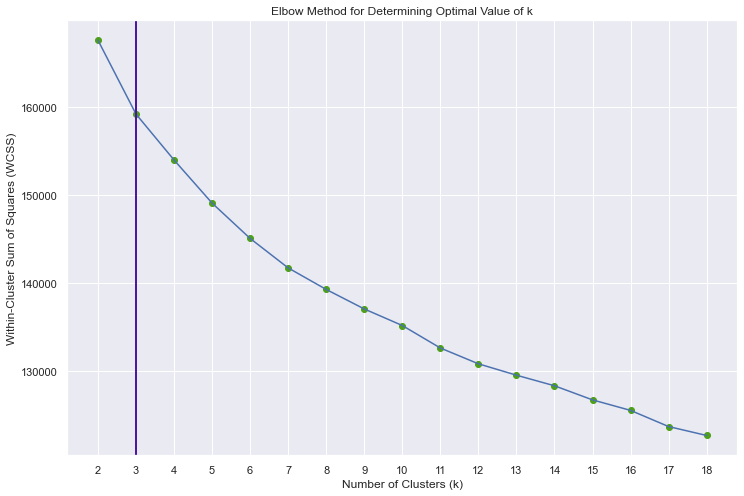

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors, color="#4DA017")
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.axvline(x=3, color='#4D17A0', lw=2)
plt.show()

In [ ]:
K = 3
# Remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(pca_75_df)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(n_clusters=3, random_state=42)
done in 0.762s


In [ ]:
# Obtain cluster memberships for each item in the data
y_preds = km.predict(pca_75_df)
pca_75_df['cluster_label'] = y_preds
centers = km.cluster_centers_

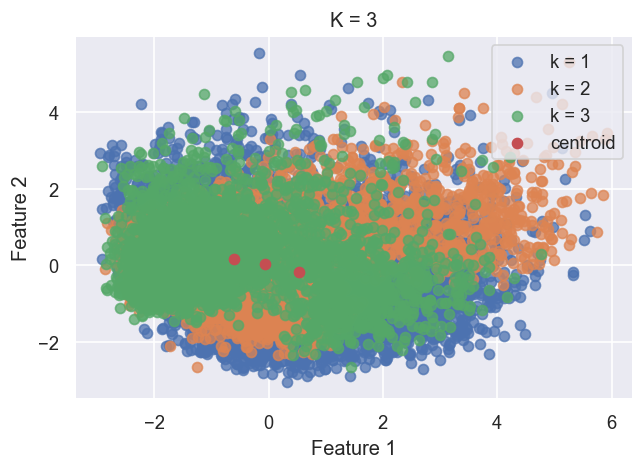

In [ ]:
plt.figure(dpi=120)
for k in range(K):
    x1 = pca_75_df[pca_75_df['cluster_label'] == k][0]
    x2 = pca_75_df[pca_75_df['cluster_label'] == k][1]
    plt.scatter(x1, x2, label="k = "+str(k+1),alpha=0.75)
# Show cluster centroid locations    
plt.scatter(centers[:,0],centers[:,1],label="centroid")
plt.legend()
plt.title(f"K = {K}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



## 7. MODELLING

To reduce computation time, we train and evaluate the following models on a 100k subset of the data. The best performing model will be trained on the whole dataset to predict the ratings for the final submission file.

In [ ]:
# Load the 100k dataset
train_df.drop('timestamp', axis=1, inplace=True)
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

### 1. SVD

The Singular Value Decomposition algorithm is a matrix factorization technique which reduces the number of features of a dataset and was popularized by Simon Funk during the Neflix Prize contest [6]. In the matrix structure, each row represents a user and each column represents a movie. The matrix elements are ratings that are given to movies by users.

In [ ]:
svd_test = SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.9746


### 2. NormalPredictor

The Normal Predictor algorithm predicts a random rating for each movie based on the distribution of the training set, which is assumed to be normal.

In [ ]:
np_test = NormalPredictor()
np_test.fit(trainset)
predictions = np_test.test(testset)
# Calculate RMSE
np_rmse = accuracy.rmse(predictions)

RMSE: 1.4448


### 3. BaselineOnly

The Baseline Only algorithm predicts the baseline estimate for a given user and movie. A baseline is calculated using either Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS).

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
blo_test.fit(trainset)
predictions = blo_test.test(testset)
# Calculate RMSE
blo_rmse = accuracy.rmse(predictions)

Estimating biases using sgd...
RMSE: 0.9735


### 4. NMF

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [ ]:
nmf_test = NMF()
nmf_test.fit(trainset)
predictions = nmf_test.test(testset)
# Calculate RMSE
nmf_rmse = accuracy.rmse(predictions)

RMSE: 1.1583


### 5. SlopeOne

The SlopeOne algorithm is a simple yet accurate collaborative filtering algorithm that uses a simple linear regression model to solve the data sparisity problem.

In [ ]:
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)

RMSE: 1.1598


### 6. CoClustering

The Co-clustering algorithm assigns clusters using a straightforward optimization method, much like k-means.

In [ ]:
cc_test = CoClustering(random_state=42)
cc_test.fit(trainset)
predictions = cc_test.test(testset)
# Calculate RMSE
cc_rmse = accuracy.rmse(predictions)

RMSE: 1.1514


### 7. SVDpp

In [ ]:
svdpp_test = SVDpp()
svdpp_test.fit(trainset)
predis = svdpp_test.test(testset)
# Calculate RMSE
svdpp_rmse = accuracy.rmse(predis)

RMSE: 0.9795


### Content-based Filtering

Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document [7]. In the following section, the model uses genres as keywords to recommend similar movies based on input from a user. The model was not used to predict ratings for the testing data, as it is too computationally expensive.

In [ ]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    # Split genre data into individual words.
    movies['keyWords'] = movies['genres'].str.replace('|', ' ')
    # Subset of the data
    movies_subset = movies[:subset_size]
    return movies_subset
 
def content_model(movie_list,top_n=10): 
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.
        
          Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    data = data_preprocessing(2000)
    # Instantiating and generating the count matrix
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(data['keyWords'])
    indices = pd.Series(data['title'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    cosine_sim = pd.DataFrame(cosine_sim, index = data.index, columns = data.index)
    # Getting the index of the movie that matches the title
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    # Getting the indexes of the 10 most similar movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    # Store movie names
    recommended_movies = []
    # Appending the names of movies
    top_50_indexes = list(listings.iloc[1:50].index)
    # Removing chosen movies
    top_indexes = np.setdiff1d(top_50_indexes,[idx_1,idx_2,idx_3])
    for i in top_indexes[:top_n]:
        recommended_movies.append(list(movies['title'])[i])
    return recommended_movies

In [ ]:
movies = movies_df.dropna()
movie_list = ['Grumpier Old Men (1995)','Ace Ventura: When Nature Calls (1995)','Father of the Bride Part II (1995)']
content_model(movie_list,top_n=10)

['Jury Duty (1995)',
 'Living in Oblivion (1995)',
 'Party Girl (1995)',
 'To Wong Foo, Thanks for Everything! Julie Newmar (1995)',
 'Billy Madison (1995)',
 'Man of the House (1995)',
 'Rent-a-Kid (1995)',
 'Tommy Boy (1995)',
 'Air Up There, The (1994)',
 'Beverly Hillbillies, The (1993)']

## 8. Performance Evaluation

We built and tested six different collaborative filtering models and compared their performance using a statistical measure known as the root mean squared error (RMSE), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

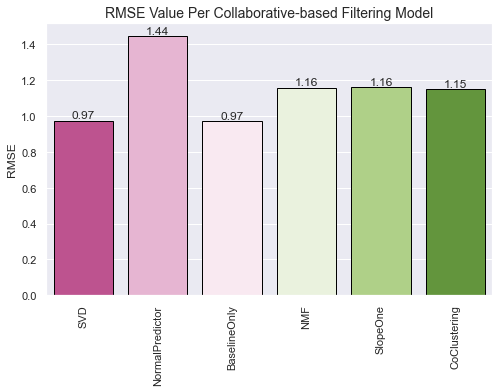

In [ ]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [svd_rmse,np_rmse,blo_rmse,nmf_rmse,slo_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='PiYG',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

## Cross Validation

Cross validation is a technique used to test the accuracy of a model's prediction on unseen data (validation sets). This is important because it can assist in picking up issues such as over/underfitting and selection bias. We used the K-fold technique to perform cross validation on our two best perfoming models, i.e. SVD and BaselineOnly.

### SVD

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9642  0.9650  0.9693  0.9723  0.9722  0.9686  0.0035  
Fit time          40.94   43.30   41.00   41.64   41.24   41.62   0.87    
Test time         0.28    0.29    0.30    0.49    0.58    0.39    0.12    


### BaselineOnly

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9613  0.9713  0.9663  0.9675  0.9641  0.9661  0.0034  
Fit time          2.26    2.21    2.00    2.26    2.30    2.21    0.11    
Test time         0.22    0.21    0.21    0.21    0.22    0.22    0.01    


## 9. Model Analysis

In [ ]:
# Load the 100k dataset
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Hyperparameter Tuning

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. We tested multiple parameters for our best performing model (i.e. SVD).

In [ ]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

***Best score:***
0.9674029343853627
***Best parameters:***
{'n_epochs': 40, 'n_factors': 400, 'init_std_dev': 0.005, 'random_state': 42}


## Results

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.9734


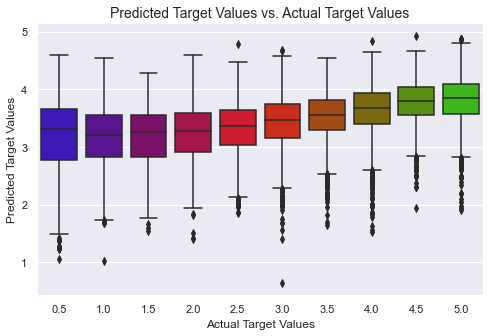

In [ ]:
# Predicted Target Values vs. Actual Target Values
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
true = new_df['rating']
pred = []
for i in predictions:
    pred.append(i.est)
fig,axis = plt.subplots(figsize=(8, 5))
sns.boxplot(x=true, y=pred, palette="brg")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.show()

In [ ]:
# Training model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39


In [ ]:
test_df

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318
...,...,...
5000014,162541,4079
5000015,162541,4467
5000016,162541,4980
5000017,162541,5689


In [ ]:
test_df["Id"] = test_df.userId.astype(str) + '_' + test_df.movieId.astype(str)
test_df

,userId,movieId,Id
0,1,2011,1_2011
1,1,4144,1_4144
2,1,5767,1_5767
3,1,6711,1_6711
4,1,7318,1_7318
...,...,...,...
5000014,162541,4079,162541_4079
5000015,162541,4467,162541_4467
5000016,162541,4980,162541_4980
5000017,162541,5689,162541_5689


In [ ]:
test_df.loc[:,'rating'] = 0
test_df.shape

(5000019, 4)

In [ ]:
test_df.loc[:,'rating'] = 0
test_df.shape

(5000019, 4)

In [ ]:
#saving the predictions as a list to add as a column for our Kaggle submission
rating = [i for i in predictions]
len(rating)

25000

In [ ]:
#change rating column
#test_df['rating'] = rating
#del test_df['userId']
#del test_df['movieId']

In [ ]:
test_df

In [ ]:
test_df['R'] = test_df['rating']
del test_df['rating']

In [ ]:
test_df['rating'] = test_df['R']

In [ ]:
del test_df['R']

In [ ]:
test_df

In [ ]:
test_df.to_csv('submissionsvd.csv', index = False)

In [ ]:
#params = {'n_epochs':40, #[30,40,50],
          'n_factors':400, #[100,200,300],
          'init_std_dev':0.005, #[0.005,0.05,0.1],
         'random_state':[42]} 
#metrics = {"RMSE": np.sqrt(mean_squared_error(true, pred))}

#experiment.log_parameters(params)
#experiment.log_metrics(metrics)
#experiment.end()

## 10. Conclusion

In this project, we succeeded in building an unsupervised machine learning model that is able to recommend movies based on content-based or collaborative filtering and is capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences. Our top performing model has a root mean squared error (RMSE) of 0.97, based on a testing set submitted to the EDSA Kaggle competition.

The BaselineOnly algorithm is a baseline approach to recommender systems, as it has a broad range of applications including dimensionality reduction, solving linear inverse problems, and data fitting. The BaselineOnly algorithm generally performs better on large datasets compared to some other models as it decomposes a matrix into constituent arrays of feature vectors corresponding to each row and each column.

## 11. Save Output